In [1]:
import os, numpy as np, pandas as pd
from sklearn.model_selection import GroupShuffleSplit

DATA_BASE = "/lhome/ext/upc150/upc1503/afasia_cat/codigos_julio2025/data"
PATH_APHBANK = os.path.join(DATA_BASE, "df_aphbank_pos_metrics.csv")   # en + es
PATH_CAT     = os.path.join(DATA_BASE, "df_catalan_pos_metrics.csv")   # ca

dfs = []
# ---------- CSV Aphasiabank ----------
df_aph = pd.read_csv(PATH_APHBANK, encoding="utf-8")
mask_en = df_aph["name_chunk_audio_path"].str.contains("aphasiabank_en", na=False)
df_aph.loc[mask_en, "LLengWAB"] = 3          # marcar inglés explícitamente (3)

dfs.append(df_aph)

# ---------- CSV catalán ----------
df_cat = pd.read_csv(PATH_CAT, encoding="utf-8")
qa_num = pd.to_numeric(df_cat["QA"], errors="coerce")
conds   = [qa_num.between(0,25,"both"), qa_num.between(25,50,"right"),
           qa_num.between(50,75,"right"), qa_num.gt(75)]
choices = ["Very severe", "Severe", "Moderate", "Mild"]
df_cat["Grup"] = np.select(conds, choices, default="Unknown")
dfs.append(df_cat)

df_raw = pd.concat(dfs, ignore_index=True)
print("Filas totales:", len(df_raw))
df_raw.head()


Filas totales: 77816


,Inicio,Fin,Marca,sex,Edat,Transcrip_name,QA,aphasia_type,name_chunk_audio,fluency_speech,...,prepositions,adjectives,adverbs,pronoun_ratio,function_words,words_per_min,words_per_utt,W,OCW,NumId
0,0.0,1656.0,al,female,60.0,scale17c.wav,90.4,Anomic,scale17c_0.0_1.656.wav,Fluent,...,0.500000,0.0,0.000000,0.0,1.000000,72.463768,2.0,1.0,0.0,NaN
1,0.0,14486.0,,male,62.0,kurland15b.wav,10.8,Broca,kurland15b_0.0_14.486.wav,Non Fluent,...,0.000000,0.0,0.000000,0.0,0.000000,4.141930,1.0,0.0,0.0,NaN
2,0.0,2851.0,try again not not <flr>,male,57.0,kurland01a.wav,NaN,aphasia,kurland01a_0.0_2.851.wav,NaN,...,0.142857,0.0,0.142857,0.0,0.428571,147.316731,7.0,1.0,0.5,NaN
3,0.0,1000.0,there w,male,72.0,tucson07a.wav,73.3,Anomic,tucson07a_0.0_1.0.wav,Fluent,...,0.000000,0.0,0.000000,1.0,0.500000,120.000000,2.0,1.0,0.5,NaN
4,0.0,15939.0,,male,56.0,kurland13d.wav,NaN,aphasia,kurland13d_0.0_15.939.wav,NaN,...,0.000000,0.0,0.000000,0.0,0.000000,3.764352,1.0,0.0,0.0,NaN


In [8]:
print(df_aph.shape[0])
print(df_cat.shape[0])
print(df_raw.shape[0])

77273
543
77816


In [11]:
for i in df_aph.columns: 
    print(i)

Inicio
Fin
Marca
sex
Edat
Transcrip_name
QA
aphasia_type
name_chunk_audio
fluency_speech
Grup
Duración
Gènere
TipusAfàsia
Fluente/No Fluente
LLengWAB
CIP
name_chunk_audio_path
num_palabras
num_palabras_unicas
promedio_palabras_por_frase
num_ininteligibles
palabras_por_minuto
palabras_por_segundo
mfcc1_mean
mfcc2_mean
mfcc3_mean
mfcc4_mean
mfcc5_mean
mfcc6_mean
mfcc7_mean
mfcc8_mean
mfcc9_mean
mfcc10_mean
mfcc11_mean
mfcc12_mean
mfcc13_mean
mfcc1_stddev
mfcc2_stddev
mfcc3_stddev
mfcc4_stddev
mfcc5_stddev
mfcc6_stddev
mfcc7_stddev
mfcc8_stddev
mfcc9_stddev
mfcc10_stddev
mfcc11_stddev
mfcc12_stddev
mfcc13_stddev
F0semitoneFrom27.5Hz_sma3nz_amean
F0semitoneFrom27.5Hz_sma3nz_stddevNorm
F0semitoneFrom27.5Hz_sma3nz_percentile20.0
F0semitoneFrom27.5Hz_sma3nz_percentile50.0
F0semitoneFrom27.5Hz_sma3nz_percentile80.0
F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2
F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope
F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope
F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope
F0sem

In [2]:
def get_lang(row):
    if "aphasiabank_en" in str(row["name_chunk_audio_path"]) or row.get("LLengWAB",0)==3: return "en"
    if "aphasiabank_es" in str(row["name_chunk_audio_path"]) or row.get("LLengWAB",0)==2: return "es"
    return "ca"

df = df_raw.dropna(subset=["QA","CIP"]).copy()
df["lang"] = df.apply(get_lang, axis=1)

# solo conservamos columnas clave para el split
df_chunks = df[["CIP", "QA", "lang"]].copy()
print(df_chunks.lang.value_counts())
df_chunks.head()


lang
en    69862
es     1064
ca      294
Name: count, dtype: int64


,CIP,QA,lang
0,scale17c,90.4,en
1,kurland15b,10.8,en
3,tucson07a,73.3,en
6,kurland17b,80.2,en
7,BU02a,63.5,en


In [3]:
df_pat = (
    df_chunks.groupby("CIP")
             .agg(QA=("QA", "mean"), lang=("lang", "first"))
             .reset_index()
)
print("Pacientes por idioma:\n", df_pat.lang.value_counts())
df_pat.head()

Pacientes por idioma:
 lang
en    386
es      8
ca      5
Name: count, dtype: int64


,CIP,QA,lang
0,01_001,44.3,ca
1,01_003,34.7,ca
2,01_004,87.7,ca
3,01_005,94.9,ca
4,01_007,96.7,ca


In [4]:
df_en_es = df_pat[df_pat.lang.isin(["en","es"])].reset_index(drop=True)

if len(df_en_es) < 3:
    # Demasiado pocos -> todo train, sin val
    df_train, df_val = df_en_es, pd.DataFrame(columns=df_pat.columns)
else:
    gss = GroupShuffleSplit(test_size=0.20, random_state=42)
    tr_idx, val_idx = next(gss.split(df_en_es, groups=df_en_es["CIP"]))
    df_train, df_val = df_en_es.iloc[tr_idx], df_en_es.iloc[val_idx]

used_cips = set(df_train.CIP) | set(df_val.CIP)
df_test_int  = df_pat[(df_pat.lang=="es") & (~df_pat.CIP.isin(used_cips))].reset_index(drop=True)
df_test_ext  = df_pat[df_pat.lang=="ca"].reset_index(drop=True)

print(f"Tamaños → Train:{len(df_train)} | Val:{len(df_val)} | "
      f"Test-int:{len(df_test_int)} | Test-ext:{len(df_test_ext)}")

Tamaños → Train:315 | Val:79 | Test-int:0 | Test-ext:5


In [5]:
for name, dframe in [("TRAIN", df_train), ("VAL", df_val),
                     ("TEST-INT", df_test_int), ("TEST-EXT", df_test_ext)]:
    print(f"\n{name} ({len(dframe)} pacientes)")
    display(dframe.head())


TRAIN (315 pacientes)


,CIP,QA,lang
1,02_003,41.2,es
2,02_007,41.8,es
4,ACWT01a,63.9,en
6,ACWT03a,69.3,en
7,ACWT04a,96.0,en



VAL (79 pacientes)


,CIP,QA,lang
0,02_002,46.8,es
3,02_008,82.6,es
5,ACWT02a,74.6,en
9,ACWT07a,95.0,en
15,BU01a,85.7,en



TEST-INT (0 pacientes)


,CIP,QA,lang



TEST-EXT (5 pacientes)


,CIP,QA,lang
0,01_001,44.3,ca
1,01_003,34.7,ca
2,01_004,87.7,ca
3,01_005,94.9,ca
4,01_007,96.7,ca


In [6]:
def count_chunks(cips, df_chunks):
    """Devuelve cuántas filas (chunks) del CSV original pertenecen a los CIPs dados."""
    return df_chunks[df_chunks["CIP"].isin(cips)].shape[0]

chunk_train    = count_chunks(df_train["CIP"],     df_chunks)
chunk_val      = count_chunks(df_val["CIP"],       df_chunks)
chunk_test_int = count_chunks(df_test_int["CIP"],  df_chunks)
chunk_test_ext = count_chunks(df_test_ext["CIP"],  df_chunks)

print("‣ Pacientes  |  Chunks")
print(f"TRAIN     : {len(df_train):>3} | {chunk_train}")
print(f"VAL       : {len(df_val):>3} | {chunk_val}")
print(f"TEST-INT  : {len(df_test_int):>3} | {chunk_test_int}")
print(f"TEST-EXT  : {len(df_test_ext):>3} | {chunk_test_ext}")


‣ Pacientes  |  Chunks
TRAIN     : 315 | 56413
VAL       :  79 | 14513
TEST-INT  :   0 | 0
TEST-EXT  :   5 | 294


In [1]:
# ==============================================
# Quick-check de splits Afasia – solo pandas
# ==============================================

import os, re, datetime, numpy as np, pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# -------- PARÁMETROS ---------------------------------
DATA_BASE   = "/lhome/ext/upc150/upc1503/afasia_cat/codigos_julio2025/data"
PATH_APHBANK = os.path.join(DATA_BASE, "df_aphbank_pos_metrics.csv")   # en + es
PATH_CAT    = os.path.join(DATA_BASE, "df_catalan_pos_metrics.csv")    # ca

# Carpetas de audio que identifican el idioma (añade las que necesites)
PAT_EN = ["aphasiabank_en", "aphbank_en"]
PAT_ES = ["aphasiabank_es"]
# Si tienes alguna carpeta específica de catalán ponla aquí:
PAT_CA = []                       

# Para forzar LLengWAB → inglés
FORCE_LLENG_EN_VALUE = 3          # 3 == inglés en tus ficheros
# ------------------------------------------------------

def load_csv(path):
    if not os.path.isfile(path):
        print(f"⚠️  No existe {path}")
        return pd.DataFrame()
    return pd.read_csv(path, encoding="utf-8")

df_aph = load_csv(PATH_APHBANK)
df_cat = load_csv(PATH_CAT)

# Marcar inglés en aphbank si LLengWAB no venía correcto
if not df_aph.empty:
    mask_en = df_aph["name_chunk_audio_path"].str.contains("aphasiabank_en", na=False)
    df_aph.loc[mask_en, "LLengWAB"] = FORCE_LLENG_EN_VALUE

# Concatenar todo
df = (
    pd.concat([df_aph, df_cat], ignore_index=True)
      .dropna(subset=["QA", "CIP", "name_chunk_audio_path"])
)

# ---------- DETECCIÓN DE IDIOMA ------------------------
def lang_from_row(row):
    path = row["name_chunk_audio_path"]
    # 1) por carpeta
    if any(pat in path for pat in PAT_EN): return "en"
    if any(pat in path for pat in PAT_ES): return "es"
    if any(pat in path for pat in PAT_CA): return "ca"
    # 2) por columna LLengWAB (opcional)
    if row.get("LLengWAB", 0) == FORCE_LLENG_EN_VALUE: return "en"
    if row.get("LLengWAB", 0) == 2:                    return "es"
    return "ca"   # por defecto catalán

df["lang"] = df.apply(lang_from_row, axis=1)

print("Filas totales:", len(df))
print("\nDistribución de filas por idioma:")
print(df["lang"].value_counts(), "\n")

# ---------- PACIENTES POR IDIOMA -----------------------
pats = df.groupby("CIP")["lang"].first()
print("Pacientes por idioma:")
print(pats.value_counts(), "\n")

# ---------- SPLITS  -----------------------------------
# a) pacientes de entrenamiento = SOLO inglés
df_en  = df[df.lang == "en"].copy()
df_es  = df[df.lang == "es"].copy()        # test-int
df_ca  = df[df.lang == "ca"].copy()        # test-ext

# → conteo de pacientes y chunks
def stats(name, d):
    print(f"{name:9} | pacientes = {d['CIP'].nunique():3d} | filas = {len(d):5d}")

stats("en pool", df_en)
stats("es pool", df_es)
stats("ca pool", df_ca)
print("")

# 80-20 Split (pacientes) dentro de inglés
if df_en["CIP"].nunique() >= 2:
    gss = GroupShuffleSplit(test_size=0.20, random_state=42)
    tr_idx, val_idx = next(gss.split(df_en, groups=df_en["CIP"]))
    df_tr, df_val = df_en.iloc[tr_idx], df_en.iloc[val_idx]
else:
    df_tr, df_val = df_en.copy(), pd.DataFrame(columns=df_en.columns)

# test-int / test-ext ya están completos
df_tint = df_es
df_text = df_ca

print("=== PACIENTES ===")
print(f"Train    : {df_tr['CIP'].nunique():3d}")
print(f"Val      : {df_val['CIP'].nunique():3d}")
print(f"Test-int : {df_tint['CIP'].nunique():3d}")
print(f"Test-ext : {df_text['CIP'].nunique():3d}\n")

print("=== FILAS (chunks) ===")
stats("Train   ", df_tr)
stats("Val     ", df_val)
stats("Test-int", df_tint)
stats("Test-ext", df_text)

# ---------- VISUAL EXTRA OPCIONAL ----------------------
# Ver 3 ejemplos de paths jamás detectados como audio en inglés
misdetect = df[(df.lang != "en") & df["name_chunk_audio_path"].str.contains("en", na=False)]
if not misdetect.empty:
    print("\n⚠️  Ejemplos de filas marcadas como NO-inglés pese a contener 'en' en la ruta:")
    display(misdetect[["CIP", "name_chunk_audio_path"]].head(3))


Filas totales: 71220

Distribución de filas por idioma:
lang
en    69862
es     1064
ca      294
Name: count, dtype: int64 

Pacientes por idioma:
lang
en    386
es      8
ca      5
Name: count, dtype: int64 

en pool   | pacientes = 386 | filas = 69862
es pool   | pacientes =   8 | filas =  1064
ca pool   | pacientes =   5 | filas =   294

=== PACIENTES ===
Train    : 308
Val      :  78
Test-int :   8
Test-ext :   5

=== FILAS (chunks) ===
Train     | pacientes = 308 | filas = 56105
Val       | pacientes =  78 | filas = 13757
Test-int  | pacientes =   8 | filas =  1064
Test-ext  | pacientes =   5 | filas =   294

⚠️  Ejemplos de filas marcadas como NO-inglés pese a contener 'en' en la ruta:


,CIP,name_chunk_audio_path
15,TCU06a,/content/drive/MyDrive/tesis_monica/afasia/dat...
421,TCU04a,/content/drive/MyDrive/tesis_monica/afasia/dat...
673,TCU04a,/content/drive/MyDrive/tesis_monica/afasia/dat...


Filas totales: 77,816

Chunks encontrados para kurland19d: 113


,name_chunk_audio_path,Inicio,Fin,Marca
0,/content/drive/MyDrive/tesis_monica/afasia/dat...,15715.0,16414.0,yeah
1,/content/drive/MyDrive/tesis_monica/afasia/dat...,23746.0,25058.0,yes
2,/content/drive/MyDrive/tesis_monica/afasia/dat...,26172.0,27936.0,oh yes
3,/content/drive/MyDrive/tesis_monica/afasia/dat...,27936.0,32609.0,oh oh wonderful
4,/content/drive/MyDrive/tesis_monica/afasia/dat...,32609.0,34654.0,i so happy



Dimensión del vector agregado: 152


,Inicio,Fin,Edat,Duración,Gènere,TipusAfàsia,LLengWAB,num_palabras,num_palabras_unicas,promedio_palabras_por_frase
media_por_paciente,516526.920354,522111.80531,71.0,5584.884956,2.0,NaN,3.0,7.238938,4.176991,4.185841


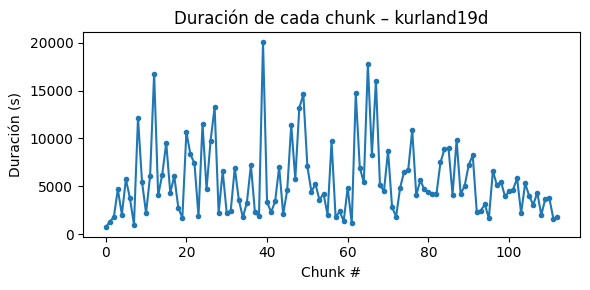

In [1]:
# ============================================
# ⚙️ 1. CONFIGURA RUTAS + CARGA CSV COMPLETO
# ============================================
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt

DATA_BASE   = "/lhome/ext/upc150/upc1503/afasia_cat/codigos_julio2025/data"
CSV_APHBANK = os.path.join(DATA_BASE, "df_aphbank_pos_metrics.csv")
CSV_CAT     = os.path.join(DATA_BASE, "df_catalan_pos_metrics.csv")

df = pd.concat([
    pd.read_csv(CSV_APHBANK, encoding="utf-8"),
    pd.read_csv(CSV_CAT, encoding="utf-8")
])

print(f"Filas totales: {len(df):,}")

# =====================================================
# 🧑‍⚕️ 2. ELIGE UN PACIENTE  (→ cambia el CIP a voluntad)
# =====================================================
CIP_SEL = "kurland19d"          # ← pon aquí cualquier CIP válido
df_p    = df[df["CIP"] == CIP_SEL].reset_index(drop=True)

if df_p.empty:
    raise ValueError(f"No hay filas para el paciente {CIP_SEL}")

print(f"\nChunks encontrados para {CIP_SEL}: {len(df_p)}")
display(df_p.loc[:, ["name_chunk_audio_path",
                     "Inicio", "Fin", "Marca"]].head())  # muestra columnas clave

# =====================================================
# 🧮 3. AGREGA TAL Y COMO HACE `build_patient()`
#      (solo parte numérica, sin llamar a wav2vec / LaBSE)
# =====================================================
# 3.1 Selecciona solo columnas numéricas (excluye QA, CIP, lang…)
DROP  = ["QA", "CIP", "lang"]
num_cols = [c for c in df_p.columns if c not in DROP and
            pd.api.types.is_numeric_dtype(df_p[c])]

# 3.2 Calcula la media columna a columna
vec = df_p[num_cols].mean(axis=0)

print(f"\nDimensión del vector agregado: {vec.shape[0]}")
display(vec.to_frame("media_por_paciente").T.iloc[:, :10])   # muestro primeros 10 valores

# =========== 4. OPCIONAL: VISUALIZA ALGUNA VARIABLE ===========
plt.figure(figsize=(6,3))
plt.plot(df_p["Fin"] - df_p["Inicio"], ".-")
plt.xlabel("Chunk #"); plt.ylabel("Duración (s)")
plt.title(f"Duración de cada chunk – {CIP_SEL}")
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd, os

CSV = "/lhome/ext/upc150/upc1503/afasia_cat/codigos_julio2025/data/df_aphbank_pos_metrics.csv"
df = pd.read_csv(CSV, nrows=1)     # solo 1 fila para no saturar la memoria
print(f"{len(df.columns)} columnas:")
for c in df.columns: print(" •", c)


163 columnas:
 • Inicio
 • Fin
 • Marca
 • sex
 • Edat
 • Transcrip_name
 • QA
 • aphasia_type
 • name_chunk_audio
 • fluency_speech
 • Grup
 • Duración
 • Gènere
 • TipusAfàsia
 • Fluente/No Fluente
 • LLengWAB
 • CIP
 • name_chunk_audio_path
 • num_palabras
 • num_palabras_unicas
 • promedio_palabras_por_frase
 • num_ininteligibles
 • palabras_por_minuto
 • palabras_por_segundo
 • mfcc1_mean
 • mfcc2_mean
 • mfcc3_mean
 • mfcc4_mean
 • mfcc5_mean
 • mfcc6_mean
 • mfcc7_mean
 • mfcc8_mean
 • mfcc9_mean
 • mfcc10_mean
 • mfcc11_mean
 • mfcc12_mean
 • mfcc13_mean
 • mfcc1_stddev
 • mfcc2_stddev
 • mfcc3_stddev
 • mfcc4_stddev
 • mfcc5_stddev
 • mfcc6_stddev
 • mfcc7_stddev
 • mfcc8_stddev
 • mfcc9_stddev
 • mfcc10_stddev
 • mfcc11_stddev
 • mfcc12_stddev
 • mfcc13_stddev
 • F0semitoneFrom27.5Hz_sma3nz_amean
 • F0semitoneFrom27.5Hz_sma3nz_stddevNorm
 • F0semitoneFrom27.5Hz_sma3nz_percentile20.0
 • F0semitoneFrom27.5Hz_sma3nz_percentile50.0
 • F0semitoneFrom27.5Hz_sma3nz_percentile80.0
 •